In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

data = pd.read_csv("data/dataset.csv")


feature_list = [
    item for item in Path("features_list.txt").read_text().split("\n") if item
]

In [2]:
data.drop(data.loc[data["def_45"].isna()].index, inplace=True)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import re


class Preprocessor:
    feature_list: list[str]
    column_transformer: ColumnTransformer
    exclude_cols: list[str]
    categorized_columns: dict[str, list[str]]

    def __init__(self, feature_list: list[str], exclude_cols: list[str]) -> None:
        self.feature_list = feature_list
        self.exclude_cols = exclude_cols

    def _init_transformer_params(self) -> None:
        self.transformer_params = {
            "transformers": [
                ("cats", OrdinalEncoder(), self.categorized_columns.get("categorical")),
                (
                    "numscaler",
                    StandardScaler(),
                    self.categorized_columns.get("numeric"),
                ),
            ],
            "remainder": "passthrough",
            "verbose": True,
        }

    def _train_transformer(self, data: pd.DataFrame) -> None:
        self._init_transformer_params()
        self.column_transformer = ColumnTransformer(**self.transformer_params)
        self.column_transformer.fit(data)

    def _categorize_columns(self, data: pd.DataFrame) -> None:
        numeric_cols = []
        boolean_cols = []
        categorical_cols = []

        for col in data.columns:
            # Булевые (bool или содержат только 0/1, True/False)
            if data[col].dtype == "bool":
                boolean_cols.append(col)
            # Числовые (int, float)
            elif pd.api.types.is_numeric_dtype(data[col]):
                # Проверяем, не является ли числовая колонка на самом деле булевой
                unique_vals = data[col].dropna().unique()
                if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
                    boolean_cols.append(col)
                else:
                    numeric_cols.append(col)
            # Категориальные (object, category, datetime)
            else:
                categorical_cols.append(col)

        self.categorized_columns = {
            "numeric": numeric_cols,
            "boolean": boolean_cols,
            "categorical": categorical_cols,
        }

    @staticmethod
    def _remove_duplicates(data: pd.DataFrame) -> pd.DataFrame:
        return data.drop_duplicates()

    @staticmethod
    def _fill_missing_values(
        data: pd.DataFrame, num_cols: list[str], cat_cols: list[str]
    ) -> pd.DataFrame:
        data = data.copy()

        for col in num_cols:
            if data[col].isna().any():
                data[col].fillna(data[col].mean(), inplace=True)

        for col in cat_cols:
            if data[col].isna().any():
                mode_value = data[col].mode()
                if not mode_value.empty:
                    data[col].fillna(mode_value.iloc[0], inplace=True)

        return data

    @staticmethod
    def _remove_prefixes(columns: list[str]) -> list[str]:
        pattern = r"^(cats__|numscaler__|remainder__)"
        return [re.sub(pattern, "", col) for col in columns]

    def transform_data(self, data: pd.DataFrame) -> pd.DataFrame:
        step_0 = data[self.feature_list].copy()

        # Сохраняем excluded колонки ДО обработки
        excluded_data = step_0[self.exclude_cols].copy()

        self._categorize_columns(step_0.drop(columns=self.exclude_cols))

        step_1 = self._remove_duplicates(step_0.drop(columns=self.exclude_cols))

        # Сохраняем индексы после удаления дубликатов
        valid_indices = step_1.index

        step_2 = self._fill_missing_values(
            step_1,
            self.categorized_columns.get("numeric"),
            self.categorized_columns.get("categorical"),
        )

        # Добавляем excluded колонки ТОЛЬКО для сохранившихся индексов
        for col in self.exclude_cols:
            step_2[col] = excluded_data.loc[valid_indices, col].values

        self._train_transformer(step_2)

        step_3_array = self.column_transformer.transform(step_2)
        step_3 = pd.DataFrame(
            step_3_array,
            columns=self._remove_prefixes(
                self.column_transformer.get_feature_names_out()
            ),
        )

        return step_3

In [4]:
train_preprocessor = Preprocessor(
    feature_list=feature_list, exclude_cols=["application_datetime", "def_45"]
)

test_preprocessor = Preprocessor(
    feature_list=feature_list, exclude_cols=["application_datetime", "def_45"]
)

valid_preprocessor = Preprocessor(
    feature_list=feature_list, exclude_cols=["application_datetime", "def_45"]
)

In [5]:
from utils import split_data


train_valid, test = split_data(data, split_column="application_datetime", ratio=0.8)


train, valid = split_data(train_valid, split_column="application_datetime", ratio=0.8)

del train_valid

In [6]:
train = train_preprocessor.transform_data(train)
test = test_preprocessor.transform_data(test)
valid = valid_preprocessor.transform_data(valid)

[ColumnTransformer] ..... (1 of 2) Processing numscaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing numscaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing numscaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


/tmp/ipykernel_35695/1670700594.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
/tmp/ipykernel_35695/1670700594.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import get_scorer_names, roc_auc_score, roc_curve
from catboost import CatBoostClassifier, Pool

cat_features = train_preprocessor.categorized_columns.get("categorical")
train_target = train.pop("def_45")
valid_target = valid.pop("def_45")
test_target = test.pop("def_45")


train_pool = Pool(
    train.drop(columns=["application_datetime"]),
    label=train_target,
    cat_features=cat_features,
)

valid_pool = Pool(
    valid.drop(columns=["application_datetime"]),
    label=valid_target,
    cat_features=cat_features,
)

test_pool = Pool(
    test.drop(columns=["application_datetime"]),
    label=test_target,
    cat_features=cat_features,
)

In [8]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    auto_class_weights="Balanced",
    early_stopping_rounds=50,
    eval_metric="AUC",
    verbose=100,
)

model.fit(train_pool)

0:	total: 49.6ms	remaining: 49.6s
100:	total: 222ms	remaining: 1.97s
200:	total: 365ms	remaining: 1.45s
300:	total: 509ms	remaining: 1.18s
400:	total: 679ms	remaining: 1.01s
500:	total: 847ms	remaining: 843ms
600:	total: 1s	remaining: 665ms
700:	total: 1.16s	remaining: 494ms
800:	total: 1.3s	remaining: 324ms
900:	total: 1.46s	remaining: 160ms
999:	total: 1.61s	remaining: 0us


In [9]:
p_v = model.predict(valid_pool)
print("ROC AUC: ", roc_auc_score(valid_target.to_list(), p_v))

ROC AUC:  0.9818424137799893


In [10]:
p_t = model.predict(test_pool)
print("ROC AUC: ", roc_auc_score(test_target.to_list(), p_t))

ROC AUC:  0.9900197628458498


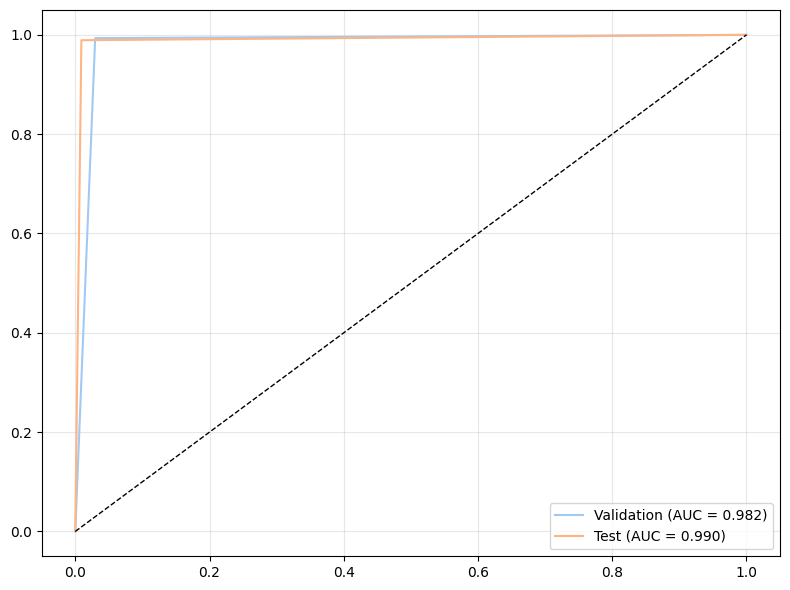

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=(8, 6))


valid_fpr, valid_tpr, _ = roc_curve(valid_target.to_list(), p_v)
test_fpr, test_tpr, _ = roc_curve(test_target.to_list(), p_t)

# Вычисляем AUC для отображения в легенде
valid_auc = auc(valid_fpr, valid_tpr)
test_auc = auc(test_fpr, test_tpr)

# Устанавливаем палитру
sns.set_palette("pastel")

sns.lineplot(x=valid_fpr, y=valid_tpr, label=f"Validation (AUC = {valid_auc:.3f})")
sns.lineplot(x=test_fpr, y=test_tpr, label=f"Test (AUC = {test_auc:.3f})")

# Добавляем диагональную линию (случайный классификатор)
plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random (AUC = 0.5)")

# Настройки графика

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Обучение модели, валидация
Как валидировать? Как тестировать? В чём отличие?)

Ответ: Валидационная выборка нужна для того, чтобы отслеживать стабильность в обучении модели во время подбора гиперпараметров и тестирования. Тестовая выборка нужна для итоговой оценки качества модели на новых данных.

Фукнции валидации:
- Отслеживание переобучения
- Выбор оптимальных гиперпараметров
- Сравнение разных архитектур моделей

Функции тестовой выборки:
- Объективная оценка производительности на "невиденных" данных
- Оценка способности модели к генерализации

Переделаем предикт в score и посмотрим распределение на тестовой выборке

In [12]:
test_probas = model.predict_proba(test_pool)

Доменная область скоринга

In [13]:
test_scores = (test_probas[:, 0] * 1000).astype(np.int16)

test["model_score"] = test_scores
test["resolution"] = test_target

In [14]:
test.head()

,avg_loan_term_months,credit_score_volatility_3y,OKB_score,antibankrupt_score,avg_time_since_account_open,num_loans_with_guarantor,total_interest_paid_5y,gamma_refactor_pod,proportion_salary_deposited,num_late_payments_last_24m_7,...,monthly_payment_burden,num_settled_defaults_5y_194,frequency_of_balance_transfers_2y,id_2804_foo,id_7438_quux,id_9625_foo,max_utilization_single_card_half,application_datetime,model_score,resolution
0,-1.747944,-0.09615,0.702169,0.585609,0.263496,-0.052499,-0.062575,0.391485,-1.487229,0.0,...,-0.14955,0.0,0.414412,1,0,0,NaN,2024-04-06 00:08:29,1,1
1,-0.977668,0.546555,-0.539779,0.08769,0.263496,2.325138,-0.086941,0.072094,-0.19106,0.0,...,-0.14955,-6.186836,-0.281972,1,1,1,0.0,2024-04-06 00:53:52,1,1
2,-0.003496,0.12497,0.531092,0.004703,0.263496,-0.052499,0.017955,-0.760828,0.26344,0.0,...,-0.14955,0.0,0.414412,1,0,0,NaN,2024-04-06 01:30:35,0,1
3,-2.223702,-0.183508,-0.086742,0.004703,0.263496,-1.241318,-0.050433,-1.966536,-1.861772,0.0,...,-0.14955,0.0,0.414412,0,1,1,1.0,2024-04-06 02:13:19,0,1
4,-0.248927,0.944356,-0.49797,0.502623,0.263496,-0.052499,-0.022188,-0.043433,0.120357,0.0,...,-0.14955,0.0,0.414412,1,0,1,0.0,2024-04-06 03:33:07,1,1


In [15]:
print(
    "Высокая уверенность и не просрочил (score > 500):",
    test.query("model_score > 500 and resolution == 0").shape[0],
)
print(
    "Низкая уверенность и не просрочил (score < 500):",
    test.query("model_score < 500 and resolution == 0").shape[0],
)
print(
    "Высокая уверенность и просрочил (score > 500):",
    test.query("model_score > 500 and resolution == 1").shape[0],
)
print(
    "Низкая уверенность и просрочил (score < 500):",
    test.query("model_score < 500 and resolution ==0").shape[0],
)
print("Общее число юзеров:", test.shape[0])

Высокая уверенность и не просрочил (score > 500): 1199
Низкая уверенность и не просрочил (score < 500): 11
Высокая уверенность и просрочил (score > 500): 9
Низкая уверенность и просрочил (score < 500): 11
Общее число юзеров: 2038


In [16]:
test["model_score"].describe()

count    2038.000000
mean      594.101570
std       477.814701
min         0.000000
25%         3.000000
50%       993.000000
75%       999.000000
max       999.000000
Name: model_score, dtype: float64

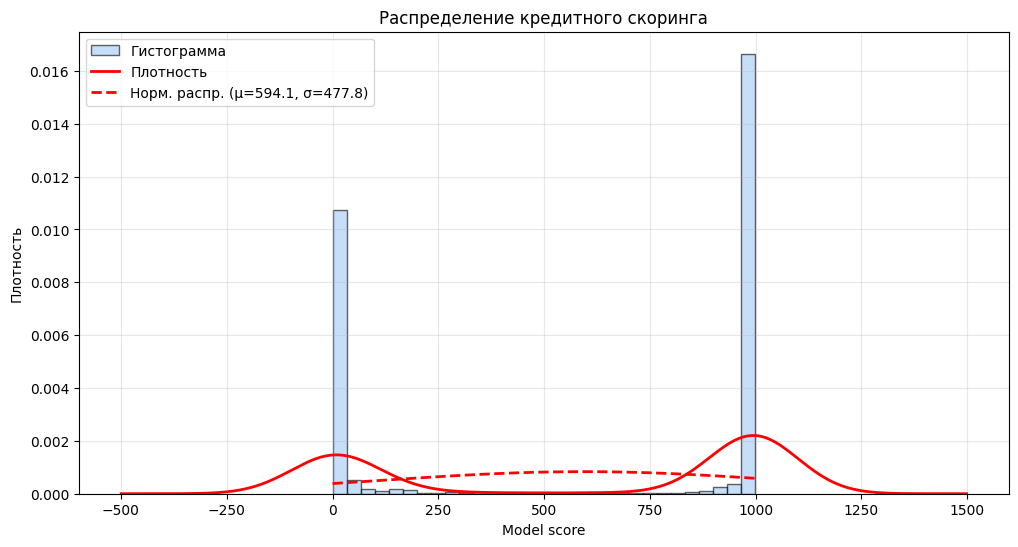

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

fig = plt.figure(figsize=(12, 6))


# Гистограмма + плотность распределения
test["model_score"].plot(
    kind="hist",
    bins=30,
    density=True,  # нормализация для наложения KDE
    alpha=0.6,
    edgecolor="black",
    label="Гистограмма",
)

# Добавляем KDE
test["model_score"].plot(kind="kde", linewidth=2, color="red", label="Плотность")


# Нормальное распределение (пунктирная линия)
mu = test["model_score"].mean()
sigma = test["model_score"].std()
x = np.linspace(
    test["model_score"].min(),
    test["model_score"].max(),
    100,
)
normal_dist = stats.norm.pdf(x, mu, sigma)

plt.plot(
    x,
    normal_dist,
    "r--",  # красная пунктирная линия
    linewidth=2,
    label=f"Норм. распр. (μ={mu:.1f}, σ={sigma:.1f})",
)


plt.xlabel("Model score")
plt.ylabel("Плотность")
plt.title("Распределение кредитного скоринга")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Попробуем понять чо происходит на дне, неделе и месяце

In [18]:
test_with_dates = test.copy()

In [19]:
test_with_dates["application_datetime"] = pd.to_datetime(test["application_datetime"])

test_with_dates["week"] = test_with_dates["application_datetime"].dt.isocalendar().week

test_with_dates["day"] = test_with_dates["application_datetime"].dt.day

test_with_dates["day_of_year"] = test_with_dates["application_datetime"].dt.dayofyear

In [20]:
test_with_dates

,avg_loan_term_months,credit_score_volatility_3y,OKB_score,antibankrupt_score,avg_time_since_account_open,num_loans_with_guarantor,total_interest_paid_5y,gamma_refactor_pod,proportion_salary_deposited,num_late_payments_last_24m_7,...,id_2804_foo,id_7438_quux,id_9625_foo,max_utilization_single_card_half,application_datetime,model_score,resolution,week,day,day_of_year
0,-1.747944,-0.09615,0.702169,0.585609,0.263496,-0.052499,-0.062575,0.391485,-1.487229,0.0,...,1,0,0,NaN,2024-04-06 00:08:29,1,1,14,6,97
1,-0.977668,0.546555,-0.539779,0.08769,0.263496,2.325138,-0.086941,0.072094,-0.19106,0.0,...,1,1,1,0.0,2024-04-06 00:53:52,1,1,14,6,97
2,-0.003496,0.12497,0.531092,0.004703,0.263496,-0.052499,0.017955,-0.760828,0.26344,0.0,...,1,0,0,NaN,2024-04-06 01:30:35,0,1,14,6,97
3,-2.223702,-0.183508,-0.086742,0.004703,0.263496,-1.241318,-0.050433,-1.966536,-1.861772,0.0,...,0,1,1,1.0,2024-04-06 02:13:19,0,1,14,6,97
4,-0.248927,0.944356,-0.49797,0.502623,0.263496,-0.052499,-0.022188,-0.043433,0.120357,0.0,...,1,0,1,0.0,2024-04-06 03:33:07,1,1,14,6,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033,-0.199841,-0.151406,-0.984553,-1.779508,0.007374,-0.052499,-0.072214,0.65225,0.793691,0.0,...,1,0,1,1.0,2024-04-30 21:23:28,999,0,18,30,121
2034,-1.136254,-0.556727,-0.947702,0.959049,0.263496,-1.241318,-0.053479,-1.973266,-0.687644,0.0,...,1,0,1,NaN,2024-04-30 21:54:10,999,0,18,30,121
2035,-0.505686,-0.316816,-1.268992,1.000542,0.263496,-0.052499,-0.038066,-0.375159,0.377066,0.0,...,0,1,1,0.0,2024-04-30 22:12:55,999,0,18,30,121
2036,0.019159,-0.401107,2.707495,-2.858334,-1.605501,1.136319,-0.079186,0.640293,0.966233,0.0,...,0,0,0,1.0,2024-04-30 23:51:05,999,0,18,30,121


Распределение model score в течение одного конкретного дня

In [21]:
test_with_dates["day"].unique()

array([ 6,  7,  8, 12,  9, 13, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30], dtype=int32)

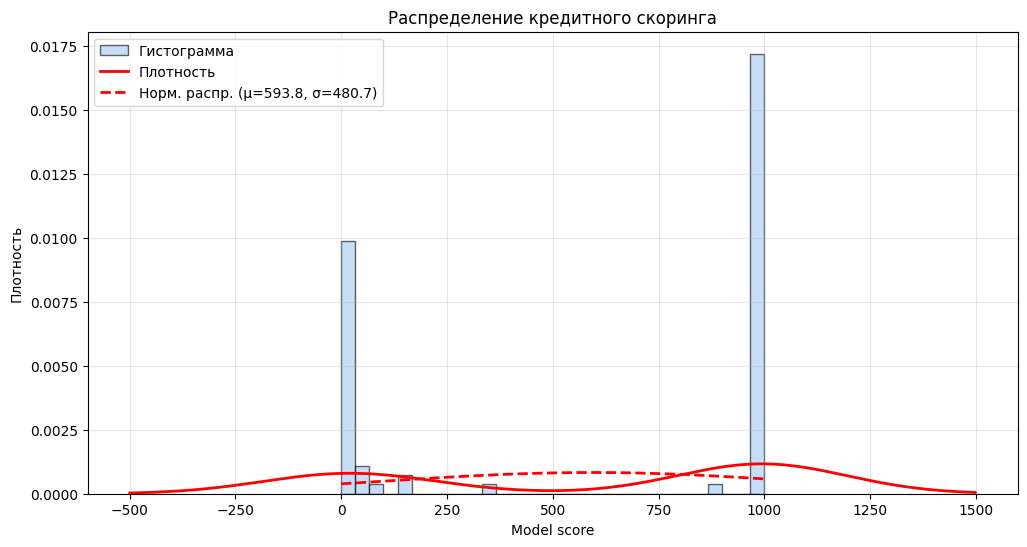

In [22]:
fig = plt.figure(figsize=(12, 6))

investigated_data = test_with_dates[test_with_dates["day"] == 22]

# Гистограмма + плотность распределения
investigated_data["model_score"].plot(
    kind="hist",
    bins=30,
    density=True,  # нормализация для наложения KDE
    alpha=0.6,
    edgecolor="black",
    label="Гистограмма",
)

# Добавляем KDE
investigated_data["model_score"].plot(
    kind="kde", linewidth=2, color="red", label="Плотность"
)


# Нормальное распределение (пунктирная линия)
mu = investigated_data["model_score"].mean()
sigma = investigated_data["model_score"].std()
x = np.linspace(
    investigated_data["model_score"].min(),
    investigated_data["model_score"].max(),
    100,
)
normal_dist = stats.norm.pdf(x, mu, sigma)

plt.plot(
    x,
    normal_dist,
    "r--",  # красная пунктирная линия
    linewidth=2,
    label=f"Норм. распр. (μ={mu:.1f}, σ={sigma:.1f})",
)


plt.xlabel("Model score")
plt.ylabel("Плотность")
plt.title("Распределение кредитного скоринга")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Распределение model score в течение одной конкретной недели 

In [23]:
test_with_dates["week"].unique()

<IntegerArray>
[14, 15, 16, 17, 18]
Length: 5, dtype: UInt32

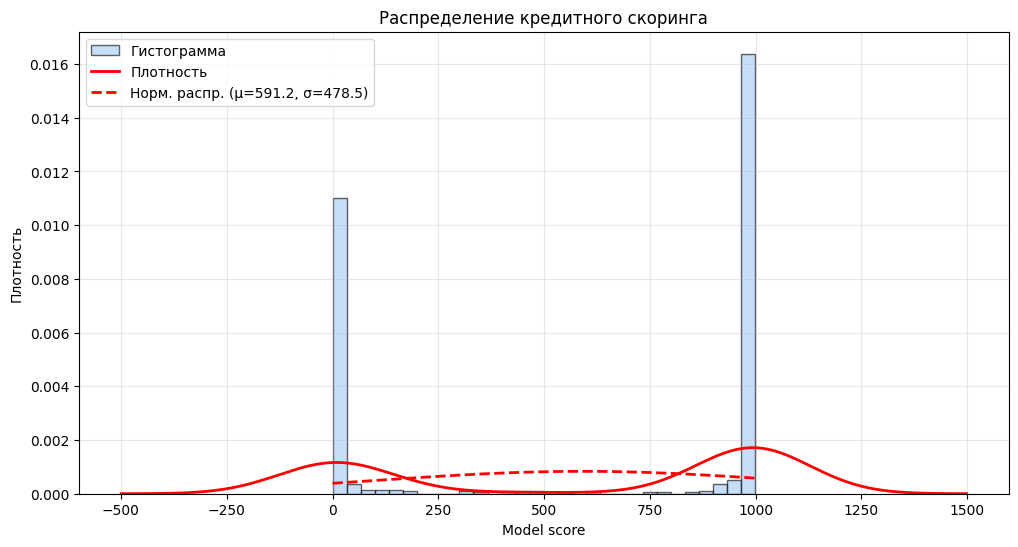

In [24]:
fig = plt.figure(figsize=(12, 6))

investigated_data = test_with_dates[test_with_dates["week"] == 16]

# Гистограмма + плотность распределения
investigated_data["model_score"].plot(
    kind="hist",
    bins=30,
    density=True,  # нормализация для наложения KDE
    alpha=0.6,
    edgecolor="black",
    label="Гистограмма",
)

# Добавляем KDE
investigated_data["model_score"].plot(
    kind="kde", linewidth=2, color="red", label="Плотность"
)


# Нормальное распределение (пунктирная линия)
mu = investigated_data["model_score"].mean()
sigma = investigated_data["model_score"].std()
x = np.linspace(
    investigated_data["model_score"].min(),
    investigated_data["model_score"].max(),
    100,
)
normal_dist = stats.norm.pdf(x, mu, sigma)

plt.plot(
    x,
    normal_dist,
    "r--",  # красная пунктирная линия
    linewidth=2,
    label=f"Норм. распр. (μ={mu:.1f}, σ={sigma:.1f})",
)


plt.xlabel("Model score")
plt.ylabel("Плотность")
plt.title("Распределение кредитного скоринга")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Попробуем нарисовать график распределения model 

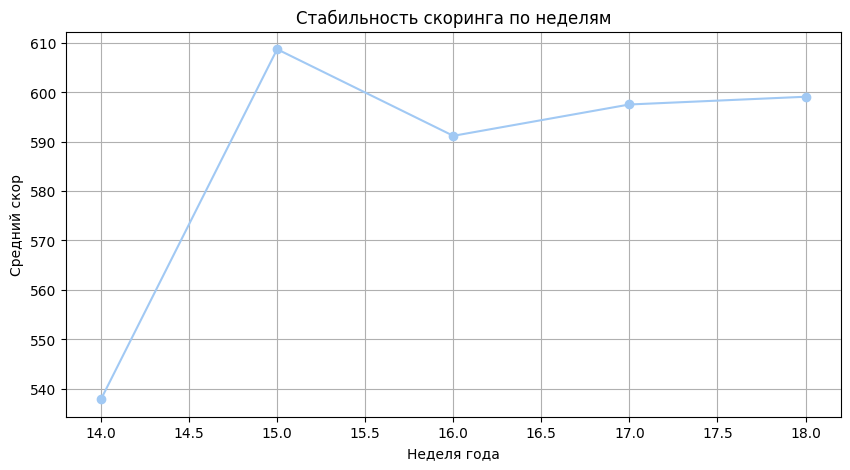

In [25]:
# Средний скор по неделям
week_avg = test_with_dates.groupby("week")["model_score"].mean()

plt.figure(figsize=(10, 5))
plt.plot(week_avg.index, week_avg.values, marker="o")
plt.title("Стабильность скоринга по неделям")
plt.xlabel("Неделя года")
plt.ylabel("Средний скор")
plt.grid(True)
plt.show()

In [26]:
# Кол-во бинов (интервалов скоринга)
bins = 10

# Разбиваем модельный скор на интервалы
bin_edges = np.linspace(
    test_with_dates["model_score"].min(), test_with_dates["model_score"].max(), bins + 1
).astype(int)

bin_labels = [f"{bin_edges[i]}-{bin_edges[i + 1]}" for i in range(len(bin_edges) - 1)]

test_with_dates["score_bin"] = pd.cut(
    test_with_dates["model_score"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True,
)

In [27]:
test_with_dates.columns

Index(['avg_loan_term_months', 'credit_score_volatility_3y', 'OKB_score',
       'antibankrupt_score', 'avg_time_since_account_open',
       'num_loans_with_guarantor', 'total_interest_paid_5y',
       'gamma_refactor_pod', 'proportion_salary_deposited',
       'num_late_payments_last_24m_7', 'avg_loan_to_income_ratio',
       'num_overdrafts_6m', 'credit_score_trend_12m_153', 'fraud_score',
       'avg_account_age_years', 'num_authorized_users_on_accounts',
       'MTS_score', 'avg_down_payment_percent', 'max_credit_limit',
       'num_early_closures_penalized_loans', 'Rusinterfinance_vector',
       'highest_account_balance', 'num_secured_loans', 'wrangle_bitport_8',
       'num_payday_loans', 'num_closed_accounts_3y_14', 'num_auto_loans_201',
       'min_loan_duration_months', 'quanta_latch_jx', 'application_datetime_0',
       'num_dormant_credit_cards', 'MTS_score_1', 'num_accounts_judgment',
       'num_family_members_as_coapplicants', 'num_auto_loans_131',
       'credit_mix_div

In [28]:
day_distribution = (
    (test_with_dates.groupby(["day_of_year", "score_bin"]).size())
    .groupby("day_of_year")
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
    .droplevel(0)
).reset_index()

/tmp/ipykernel_35695/663457968.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (test_with_dates.groupby(["day_of_year", "score_bin"]).size())


In [29]:
day_distribution

score_bin,day_of_year,0-99,99-199,199-299,299-399,399-499,499-599,599-699,699-799,799-899,899-999
0,97,0.469880,0.036145,0.000000,0.000000,0.000000,0.012048,0.000000,0.000000,0.000000,0.481928
1,98,0.402439,0.000000,0.012195,0.000000,0.000000,0.000000,0.012195,0.000000,0.000000,0.573171
2,99,0.365591,0.000000,0.010753,0.000000,0.000000,0.000000,0.010753,0.021505,0.021505,0.569892
3,100,0.464789,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.014085,0.492958
4,101,0.328358,0.000000,0.014925,0.014925,0.000000,0.000000,0.000000,0.000000,0.014925,0.626866
5,102,0.407407,0.012346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580247
6,103,0.283951,0.000000,0.012346,0.012346,0.000000,0.000000,0.012346,0.000000,0.012346,0.666667
7,104,0.389610,0.000000,0.012987,0.000000,0.000000,0.000000,0.038961,0.000000,0.000000,0.558442
8,105,0.351064,0.031915,0.010638,0.000000,0.000000,0.000000,0.000000,0.000000,0.010638,0.595745
9,106,0.476190,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.015873,0.000000,0.492063


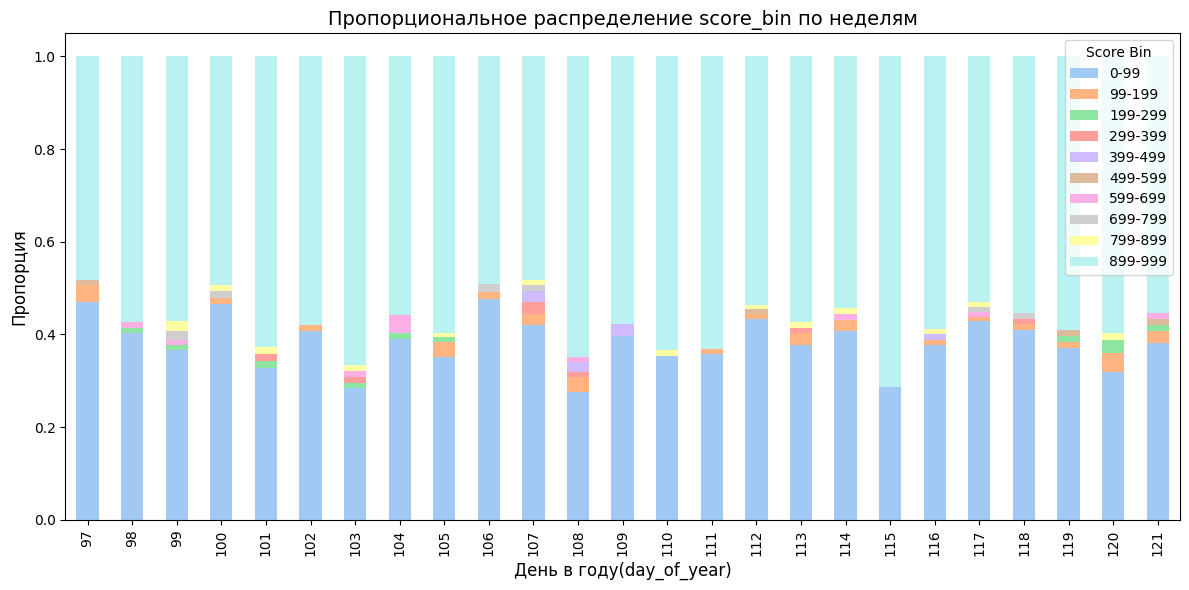

In [ ]:
# Приведение данных в форму для stacked barplot , colormap="viridis")
day_distribution.set_index("day_of_year", inplace=True)
day_distribution.plot(kind="bar", stacked=True, figsize=(12, 6))

# Настройки графика
plt.title("Пропорциональное распределение score_bin по неделям", fontsize=14)
plt.xlabel("День в году(day_of_year)", fontsize=12)
plt.ylabel("Пропорция", fontsize=12)
plt.legend(title="Score Bin")
plt.tight_layout()
plt.show()

Таблица доля одобрений 

In [57]:
def get_ar_for_cutoff(data, cutoff):
    return data.query(f"model_score > {cutoff} ").shape[0] / data.shape[0]


def get_def_for_cutoff(data, cutoff):
    return (
        data.query(f"model_score > {cutoff} and resolution == 1").shape[0]
        / data.query(f"model_score > {cutoff} ").shape[0]
    )


def get_def_for_cutoff(data, cutoff):
    above_cutoff_count = (data["model_score"] > cutoff).sum()

    if above_cutoff_count == 0:
        return np.nan

    defaults_count = ((data["model_score"] > cutoff) & (data["resolution"] == 1)).sum()
    return defaults_count / above_cutoff_count


def get_cutoff_for_ar(dat: pd.DataFrame, ar_value: float) -> float:
    sorted_scores = np.sort(dat["model_score"].values)[::-1]
    total_count = len(sorted_scores)
    ar_values = np.arange(1, total_count + 1) / total_count
    idx = np.searchsorted(ar_values, ar_value, side="right")
    if idx >= total_count:
        return sorted_scores[-1]

    return sorted_scores[idx]

Нарисуем табличку с долей одобрений по катоффу


In [64]:
estimate_ar = np.linspace(0.1, 0.9, 30)

cutoff_value = [get_cutoff_for_ar(test_with_dates, i) for i in estimate_ar]
true_ar_value = [get_ar_for_cutoff(test_with_dates, i) for i in cutoff_value]
def_rate_for_cutoff = [get_def_for_cutoff(test_with_dates, i) for i in cutoff_value]

def_rate = pd.DataFrame(
    {
        "estimate_ar": estimate_ar,
        "cutoff_value": cutoff_value,
        "true_ar_value": true_ar_value,
        "def_rate": def_rate_for_cutoff,
    }
)

def_rate.dropna(inplace=True)
def_rate.drop_duplicates(subset=["cutoff_value", "true_ar_value"], inplace=True)

def_rate

,estimate_ar,cutoff_value,true_ar_value,def_rate
11,0.403448,998,0.387635,0.000000
13,0.458621,996,0.453876,0.000000
14,0.486207,994,0.484298,0.000000
15,0.513793,990,0.513739,0.000000
16,0.541379,977,0.541217,0.000907
17,0.568966,925,0.568695,0.001726
18,0.596552,363,0.596173,0.011523
19,0.624138,74,0.623160,0.049606
20,0.651724,27,0.651619,0.088855
21,0.679310,13,0.675662,0.121278


In [ ]:
import joblib

pth_preprocessor = Path("service/model")
pth_preprocessor.mkdir(exist_ok=True, parents=True)

joblib.dump(
    test_preprocessor.column_transformer, pth_preprocessor / "column_transformer.pkl"
)

joblib.dump(model, pth_preprocessor / "model.pkl")

['service/model/model.pkl']